# ID 5059 Coursework 1
John Belcher-Heath (jbh6)

# Introduction

The task is to predict the price of a car from a subset of attributes from the Kaggle dataset.

I will complete the task following the ML checklist in the book, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. which is:

1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data
5. Explore models
6. Fine-tune models
7. Present solution
8. Launch/maintain

# 1. Frame the problem

We want to predict the price of a car (continuos) using a small selection of attributes available to us. This makes the problem a regression problem.

Since this is a regression problem the standard performance measure of Root Mean Square Error (referred to as RMSE from now on) will be used:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2}
$$

For this measure we are looking for low RMSE. This will mean small residuals and the model is a good fit for the data.

# 2. Get the data

In this section a random sleection of entries from one of the large datasets will be obtained and read into a pandas.dataframe to explore. A random selection of the large dataset will be explored since all we are doing is getting to know the data. Having a large amount of data to explore will be time consuming, but having too small (and non random sample) will mean our observations may not be valid. Taking a random sample of a large dataset should give a relatively good representation of the overall dataset, whilst minimising the amount of data requiring to be manipulated.

Note when it comes to applying the model I will include a check of the data to make sure our observations on the smaller dataset still hold.

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

# Import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import sklearn
import os
import glob
from pathlib import Path
import math

In [2]:
# folder_path: str = "/cs/studres/ID5059/Coursework/Coursework-1/data/2_medium" # uni
folder_path : str = r"/home/johnbh/personal_git/ID5059_coursework_1/data/3_large" # Desktop

if not os.path.exists(folder_path):
    raise FileNotFoundError
os.chdir(folder_path)

file_names : list = [i for i in glob.glob("*.{}".format('csv'))]

    
def read_car_data(filepath : str) -> pd.DataFrame:
    """
    Reads a filepath and returns the dataframe
    :param filepath: The location of the file to read
    :return: returns the pandas dataframe
    """
    return pd.read_csv(filepath, index_col = "vin")

frac: float = 0.6 # fraction of data to use to explore

df: pd.DataFrame = read_car_data(file_names[0]).sample(frac = frac)
sample_size: int = len(df)

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)
# check data looks roughly okay
df.head(5)

/tmp/ipykernel_33771/4125397600.py:17: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, index_col = "vin")


,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5XYPGDA37LG683372,39.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Muncie,21.0,NaN,69,47304,Kia Muncie. We are open online 24/7! Get pre-a...,I4,2400.0,I4,Gravity Gray,NaN,NaN,True,Kia,44.1 in,18.8 gal,Gasoline,NaN,66.3 in,26.0,185.0,None,NaN,NaN,NaN,True,NaN,40.2123,189 in,2020-07-02,GRAY,275622771,-85.4354,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Third Row Seating', 'Bluetoo...",Kia,7 seats,0.0,Sorento,NaN,"185 hp @ 6,000 RPM",26365.0,NaN,0,4.818182,344889.0,Kia of Muncie,NaN,"178 lb-ft @ 4,000 RPM",NaN,NaN,t89745,LX AWD,NaN,AWD,All-Wheel Drive,109.4 in,74.4 in,2020
5FNYF6H59MB019335,38.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Patchogue,19.0,NaN,6,11772,Scores 26 Highway MPG and 19 City MPG! This Ho...,V6,3500.0,V6,Black,NaN,NaN,True,Honda,40.9 in,19.5 gal,Gasoline,NaN,70.6 in,26.0,280.0,Black,NaN,NaN,NaN,True,NaN,40.7661,196.5 in,2020-09-03,BLACK,281214759,-73.0070,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Honda,8 seats,0.0,Pilot,NaN,"280 hp @ 6,000 RPM",41480.0,NaN,0,3.750000,59128.0,Baron Honda,NaN,"262 lb-ft @ 4,700 RPM",A,Automatic,t93926,EX-L AWD,NaN,AWD,All-Wheel Drive,111 in,78.6 in,2021
3GNAXJEV7JL394988,39.7 in,NaN,NaN,NaN,SUV / Crossover,NaN,Battle Creek,26.0,NaN,18,49037,LOOK! Check out this 2018 Equinox featuring gr...,I4,1500.0,I4,Storm Blue Metallic,False,False,True,Chevrolet,40.9 in,14.9 gal,Gasoline,False,65.4 in,32.0,170.0,Jet Black,False,NaN,True,False,True,42.3189,183.1 in,2020-08-22,BLUE,280079931,-85.1952,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Chevrolet,5 seats,4947.0,Equinox,1.0,NaN,23000.0,False,1422,4.142857,276956.0,Heritage Chevrolet,False,NaN,NaN,NaN,t72936,1.5T LT FWD,NaN,FWD,Front-Wheel Drive,107.3 in,72.6 in,2018
5NPD74LF0LH615918,35.7 in,NaN,NaN,NaN,Sedan,NaN,Stamford,31.0,NaN,4,6902,"PHANTOM BLACK exterior and BLACK interior, SE ...",I4,2000.0,I4,PHANTOM BLACK,NaN,NaN,True,Hyundai,42.2 in,14 gal,Gasoline,NaN,56.5 in,41.0,147.0,Black,NaN,NaN,NaN,True,NaN,41.0473,181.9 in,2020-09-05,BLACK,281351902,-73.5286,NaN,"['Steel Wheels', 'Bluetooth', 'Backup Camera']",Hyundai,5 seats,0.0,Elantra,NaN,"147 hp @ 6,200 RPM",20275.0,NaN,0,4.258065,287089.0,Stamford Hyundai,NaN,"132 lb-ft @ 4,500 RPM",A,Automatic,t85685,SE Sedan FWD,NaN,FWD,Front-Wheel Drive,106.3 in,70.9 in,2020
2T3J1RFV3LC127528,37.8 in,NaN,NaN,NaN,SUV / Crossover,NaN,Kokomo,25.0,NaN,33,46902,"Sunroof, Dual Zone A/C, Blind Spot Monitor, Wi...",I4,2500.0,I4,MAGNETIC GRAY METALLIC,NaN,NaN,True,Toyota,41 in,14.5 gal,Gasoline,NaN,68.6 in,32.0,203.0,ED20 BLACK,NaN,NaN,NaN,True,NaN,40.4424,181.5 in,2020-08-07,GRAY,278723949,-86.1271,https://s3.amazonaws.com/i.autouplinktech.com/...,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Toyota,5 seats,3.0,RAV4,NaN,NaN,38846.0,NaN,0,4.416667,340882.0,Kokomo Auto World,NaN,NaN,A,Automatic,t89235,TRD Off-Road AWD,NaN,AWD,All-Wheel Drive,105.9 in,73.4 in,2020


# 3. Explore the data

The data will now be inspected to explore what attributes are available to using the info output. Attributes with large proportion of NAs can start to be identified as well.

In [3]:
df: pd.DataFrame = df.reset_index(drop=True) # Reindex to make elements easier to quickly access
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177301 entries, 0 to 177300
Data columns (total 65 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   back_legroom             168684 non-null  object 
 1   bed                      1133 non-null    object 
 2   bed_height               20354 non-null   object 
 3   bed_length               20354 non-null   object 
 4   body_type                176600 non-null  object 
 5   cabin                    3396 non-null    object 
 6   city                     177301 non-null  object 
 7   city_fuel_economy        148018 non-null  float64
 8   combine_fuel_economy     0 non-null       float64
 9   daysonmarket             177301 non-null  int64  
 10  dealer_zip               177301 non-null  object 
 11  description              171384 non-null  object 
 12  engine_cylinders         172016 non-null  object 
 13  engine_displacement      168082 non-null  float64
 14  engi

Firstly, let's drop all attributes from above which have less than 50% non-null values, since including these may negatively effect our model if a majority of entries do not have this attribute. Using them in our model will mean the model is not very general.

In [4]:
# Drop all attributes with less than 50% non-null values
df = df.drop(columns=df.keys()[df.count() / sample_size < 0.5])

### Data types correction
Some of the attributes appear to have been imported with different datatype, for example `zip code` as `object` not `int64`. This will be due to some integer attributes containing `NaNs`, and since the system has no interpretation for `NaNs` in `integer` types, they are taken as `object` data types instead. 

To further inspect this, all `object` data types are shown below.

In [5]:
df.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177301 entries, 0 to 177300
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   back_legroom          168684 non-null  object
 1   body_type             176600 non-null  object
 2   city                  177301 non-null  object
 3   dealer_zip            177301 non-null  object
 4   description           171384 non-null  object
 5   engine_cylinders      172016 non-null  object
 6   engine_type           172016 non-null  object
 7   exterior_color        177301 non-null  object
 8   fleet                 97869 non-null   object
 9   frame_damaged         97869 non-null   object
 10  franchise_make        139890 non-null  object
 11  front_legroom         168684 non-null  object
 12  fuel_tank_volume      168684 non-null  object
 13  fuel_type             172966 non-null  object
 14  has_accidents         97869 non-null   object
 15  height           

From manual inspection there are some attributes that need further inspection to check they have been given the correct type. The first 5 entries are shown below to help.

In [6]:
pd.set_option('display.max_columns', None)
df.select_dtypes(include=object).head(5)

,back_legroom,body_type,city,dealer_zip,description,engine_cylinders,engine_type,exterior_color,fleet,frame_damaged,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,interior_color,isCab,length,listed_date,listing_color,main_picture_url,major_options,make_name,maximum_seating,model_name,power,salvage,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width
0,39.4 in,SUV / Crossover,Muncie,47304,Kia Muncie. We are open online 24/7! Get pre-a...,I4,I4,Gravity Gray,NaN,NaN,Kia,44.1 in,18.8 gal,Gasoline,NaN,66.3 in,None,NaN,189 in,2020-07-02,GRAY,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Third Row Seating', 'Bluetoo...",Kia,7 seats,Sorento,"185 hp @ 6,000 RPM",NaN,Kia of Muncie,NaN,"178 lb-ft @ 4,000 RPM",NaN,NaN,t89745,LX AWD,AWD,All-Wheel Drive,109.4 in,74.4 in
1,38.4 in,SUV / Crossover,Patchogue,11772,Scores 26 Highway MPG and 19 City MPG! This Ho...,V6,V6,Black,NaN,NaN,Honda,40.9 in,19.5 gal,Gasoline,NaN,70.6 in,Black,NaN,196.5 in,2020-09-03,BLACK,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Honda,8 seats,Pilot,"280 hp @ 6,000 RPM",NaN,Baron Honda,NaN,"262 lb-ft @ 4,700 RPM",A,Automatic,t93926,EX-L AWD,AWD,All-Wheel Drive,111 in,78.6 in
2,39.7 in,SUV / Crossover,Battle Creek,49037,LOOK! Check out this 2018 Equinox featuring gr...,I4,I4,Storm Blue Metallic,False,False,Chevrolet,40.9 in,14.9 gal,Gasoline,False,65.4 in,Jet Black,False,183.1 in,2020-08-22,BLUE,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Chevrolet,5 seats,Equinox,NaN,False,Heritage Chevrolet,False,NaN,NaN,NaN,t72936,1.5T LT FWD,FWD,Front-Wheel Drive,107.3 in,72.6 in
3,35.7 in,Sedan,Stamford,6902,"PHANTOM BLACK exterior and BLACK interior, SE ...",I4,I4,PHANTOM BLACK,NaN,NaN,Hyundai,42.2 in,14 gal,Gasoline,NaN,56.5 in,Black,NaN,181.9 in,2020-09-05,BLACK,NaN,"['Steel Wheels', 'Bluetooth', 'Backup Camera']",Hyundai,5 seats,Elantra,"147 hp @ 6,200 RPM",NaN,Stamford Hyundai,NaN,"132 lb-ft @ 4,500 RPM",A,Automatic,t85685,SE Sedan FWD,FWD,Front-Wheel Drive,106.3 in,70.9 in
4,37.8 in,SUV / Crossover,Kokomo,46902,"Sunroof, Dual Zone A/C, Blind Spot Monitor, Wi...",I4,I4,MAGNETIC GRAY METALLIC,NaN,NaN,Toyota,41 in,14.5 gal,Gasoline,NaN,68.6 in,ED20 BLACK,NaN,181.5 in,2020-08-07,GRAY,https://s3.amazonaws.com/i.autouplinktech.com/...,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Toyota,5 seats,RAV4,NaN,NaN,Kokomo Auto World,NaN,NaN,A,Automatic,t89235,TRD Off-Road AWD,AWD,All-Wheel Drive,105.9 in,73.4 in


The only attribute that can be directly converted to an integer is the `dealer_zip`, this is unlikely to provide any additional information that the `lattitude` and `longitutde` will not already give so no need to convert.This is dropped from our dataset below. 

This inspection has shown that a lot of the measurements have had units included, so these attributes will need to be converted to numerical.

In [7]:
# Drop dealer_zip
try:
    df = df.drop(columns='dealer_zip')
except KeyError:
    print("Column already dropped")

In [8]:
def convert_measurement(s: str) -> float:
    """
    Converts the measuremnt with units to a numerical value
    :param s: string measurement
    :type s: str
    :return: the actual numerical value
    """
    if type(s) == str:
        s_split: list = s.split(" ")
        try:
            return float(s_split[0])
        # If cannot convert to dtype, ie NA then return NA
        except ValueError:
            return float('NaN')
    # If already converted to correct format, ie if function accidently run twice
    else:
        return s

cols_to_convert: list = ["back_legroom", "front_legroom", "fuel_tank_volume", "height", "length", 
                         "maximum_seating", "wheelbase", "width"]

In [9]:
# Apply the function to get numerical data from the string measurements
df[cols_to_convert] = df[cols_to_convert].applymap(convert_measurement)
df[cols_to_convert] = df[cols_to_convert].astype(np.float64)

It is important to note that the attributes power and torque contain numerical data, but this cannot be simply convert at this point but will be saved for later.

Next, let's drop all the irrelevant meta data which won't be helpful with our model and will instead just increase the complexity which could lead to overfitting. For example the `description`, `interior color`, `exterior color` etc

In [10]:
df = df.drop(columns=['description', 'interior_color', 'exterior_color', 
                      'main_picture_url', 'model_name', 'sp_name', 'transmission_display',
                      'trim_name', 'trimId'])

### Fixing duplicates

It is easy to see that `engine_cylinders` and `engine_type` appear to be duplicate. Similarly so do `wheel_system` and `wheel_system_display`, as well as `make_name` and `franchise_make`.

Before dropping one of each of these, the data will be further inspected to make sure that there's no discrepancy between the two in the wider data set (i.e. not just in the head).

In [11]:
df_engine = df[['engine_cylinders', 'engine_type']]
df_engine[np.logical_xor(df_engine.engine_cylinders.isna(), df_engine.engine_type.isna())].count()

engine_cylinders    0
engine_type         0
dtype: int64

So above tells us that all entries with attributes are identical in being either NA or not, so dropping one of these attributes means no information is lost.

In [12]:
df = df.drop(columns='engine_cylinders')

For the `wheel_system` and `wheel_system_display`:

In [13]:
df_wheel = df[['wheel_system', 'wheel_system_display']]
df_wheel[np.logical_xor(df_wheel.wheel_system.isna(), df_wheel.wheel_system_display.isna())].count()

wheel_system            0
wheel_system_display    0
dtype: int64

The above implies that both attributes provide the same information for the cars. Hence deciding which to drop is irrelevant. I will choose to drop the `wheel_system_display` since wheel system has a nice short appriviation.

In [14]:
df = df.drop(columns='wheel_system_display')

Finally for make.

In [15]:
df_make = df[['make_name', 'franchise_make']]
df_make[np.logical_xor(df_make.make_name.isna(), df_make.franchise_make.isna())].count()

make_name         37411
franchise_make        0
dtype: int64

From this we can see that the `make_name` has more information than the `franchise_make`, hence the `franchise_make` is dropped.

In [16]:
df = df.drop(columns='franchise_make')

### Object type attributes
Now we have removed some of the duplicates and corrected some of the data type issues the object type attributes will be properly explored now.

In [17]:
df.select_dtypes(include=object).head(5)

,body_type,city,engine_type,fleet,frame_damaged,fuel_type,has_accidents,isCab,listed_date,listing_color,major_options,make_name,power,salvage,theft_title,torque,transmission,wheel_system
0,SUV / Crossover,Muncie,I4,NaN,NaN,Gasoline,NaN,NaN,2020-07-02,GRAY,"['Alloy Wheels', 'Third Row Seating', 'Bluetoo...",Kia,"185 hp @ 6,000 RPM",NaN,NaN,"178 lb-ft @ 4,000 RPM",NaN,AWD
1,SUV / Crossover,Patchogue,V6,NaN,NaN,Gasoline,NaN,NaN,2020-09-03,BLACK,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Honda,"280 hp @ 6,000 RPM",NaN,NaN,"262 lb-ft @ 4,700 RPM",A,AWD
2,SUV / Crossover,Battle Creek,I4,False,False,Gasoline,False,False,2020-08-22,BLUE,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Chevrolet,NaN,False,False,NaN,NaN,FWD
3,Sedan,Stamford,I4,NaN,NaN,Gasoline,NaN,NaN,2020-09-05,BLACK,"['Steel Wheels', 'Bluetooth', 'Backup Camera']",Hyundai,"147 hp @ 6,200 RPM",NaN,NaN,"132 lb-ft @ 4,500 RPM",A,FWD
4,SUV / Crossover,Kokomo,I4,NaN,NaN,Gasoline,NaN,NaN,2020-08-07,GRAY,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Toyota,NaN,NaN,NaN,NaN,A,AWD


First let's see if any of the attributes have any blaring issues with NAs.

In [18]:
df.select_dtypes(include=object).count() / sample_size

body_type        0.996046
city             1.000000
engine_type      0.970192
fleet            0.551994
frame_damaged    0.551994
fuel_type        0.975550
has_accidents    0.551994
isCab            0.551994
listed_date      1.000000
listing_color    1.000000
major_options    0.923492
make_name        1.000000
power            0.851366
salvage          0.551994
theft_title      0.551994
torque           0.840148
transmission     0.986216
wheel_system     0.955127
dtype: float64

Clerly some of the attributes are not suitable to use since they have a low number of entries. Any object attributes with less than 80% entries are removed.

In [19]:
df = df.drop(columns=df.select_dtypes(include=object).loc[:, df.select_dtypes(include=object).count() / sample_size < 0.8].keys())

This leaves:

In [20]:
df.select_dtypes(include=object).head(5)

,body_type,city,engine_type,fuel_type,listed_date,listing_color,major_options,make_name,power,torque,transmission,wheel_system
0,SUV / Crossover,Muncie,I4,Gasoline,2020-07-02,GRAY,"['Alloy Wheels', 'Third Row Seating', 'Bluetoo...",Kia,"185 hp @ 6,000 RPM","178 lb-ft @ 4,000 RPM",NaN,AWD
1,SUV / Crossover,Patchogue,V6,Gasoline,2020-09-03,BLACK,"['Leather Seats', 'Sunroof/Moonroof', 'Adaptiv...",Honda,"280 hp @ 6,000 RPM","262 lb-ft @ 4,700 RPM",A,AWD
2,SUV / Crossover,Battle Creek,I4,Gasoline,2020-08-22,BLUE,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Chevrolet,NaN,NaN,NaN,FWD
3,Sedan,Stamford,I4,Gasoline,2020-09-05,BLACK,"['Steel Wheels', 'Bluetooth', 'Backup Camera']",Hyundai,"147 hp @ 6,200 RPM","132 lb-ft @ 4,500 RPM",A,FWD
4,SUV / Crossover,Kokomo,I4,Gasoline,2020-08-07,GRAY,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Toyota,NaN,NaN,A,AWD


Since we have `daysonmarket` attribute the `listed_date` can be dropped. Additionally, `city` can assumed to have minimal effect since most cities can be assumed to have a diverse range of individuals with varying wealth and cars.

In [21]:
df = df.drop(columns=['city', 'listed_date'])

`torque` could be useful but there is too few entries (see below) for it and it is not recorded elsewhere (like `horsepower` recorded in `power` and `engine_size`). Hence I will not use this attribute for my model

In [22]:
df.torque.count() / sample_size

0.8401475456991219

In [23]:
df = df.drop(columns='torque')

For major options, since there is so much variabilty from visual inspection of naming of products, the number of major of features will be used instead. The actual usefulness of this will be explored later.

In [25]:
df.major_options = df.major_options.apply(lambda x: len(x.split(",")) if type(x) == str else "NaN").astype(np.float64)

For the remaining attributes, these will be used as categorical attributes in the model.

### Exploring the numerical attributes

Now the qualitative attributes have been dealt with it's time for the quantiative attributes.

Let's explore all the numerical attributes with an actual numerical meaning(index or listing_id have no meaning numerically). Attributes with no numerical meaning our dropped below.

In [30]:
# Quick inspection to see which numerical but non-relevant attributes need to be dropped
df.select_dtypes(include=[np.int64, np.float64])

,back_legroom,city_fuel_economy,daysonmarket,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,latitude,length,listing_id,longitude,major_options,maximum_seating,mileage,owner_count,price,savings_amount,seller_rating,sp_id,wheelbase,width,year
0,39.4,21.0,69,2400.0,44.1,18.8,66.3,26.0,185.0,40.2123,189.0,275622771,-85.4354,8.0,7.0,0.0,NaN,26365.0,0,4.818182,344889.0,109.4,74.4,2020
1,38.4,19.0,6,3500.0,40.9,19.5,70.6,26.0,280.0,40.7661,196.5,281214759,-73.0070,10.0,8.0,0.0,NaN,41480.0,0,3.750000,59128.0,111.0,78.6,2021
2,39.7,26.0,18,1500.0,40.9,14.9,65.4,32.0,170.0,42.3189,183.1,280079931,-85.1952,10.0,5.0,4947.0,1.0,23000.0,1422,4.142857,276956.0,107.3,72.6,2018
3,35.7,31.0,4,2000.0,42.2,14.0,56.5,41.0,147.0,41.0473,181.9,281351902,-73.5286,3.0,5.0,0.0,NaN,20275.0,0,4.258065,287089.0,106.3,70.9,2020
4,37.8,25.0,33,2500.0,41.0,14.5,68.6,32.0,203.0,40.4424,181.5,278723949,-86.1271,6.0,5.0,3.0,NaN,38846.0,0,4.416667,340882.0,105.9,73.4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177296,36.5,27.0,42,2500.0,43.1,16.6,63.6,34.0,182.0,41.3984,176.5,277868151,-73.5983,NaN,5.0,0.0,NaN,28324.0,0,5.000000,293796.0,104.9,71.0,2021
177297,40.1,18.0,230,3600.0,41.8,18.5,58.5,27.0,300.0,42.4453,198.4,263891267,-83.1865,8.0,5.0,NaN,NaN,29847.0,0,3.500000,61661.0,120.0,82.7,2020
177298,35.9,20.0,345,2000.0,42.2,15.9,60.7,30.0,316.0,41.0526,194.4,253763874,-73.5260,3.0,5.0,0.0,NaN,61275.0,0,3.000000,65001.0,115.8,80.8,2020
177299,35.4,26.0,12,2000.0,43.5,15.9,63.6,34.0,148.0,42.7538,175.2,280579582,-83.4806,4.0,5.0,48950.0,1.0,17843.0,611,4.232558,337149.0,103.7,78.2,2016


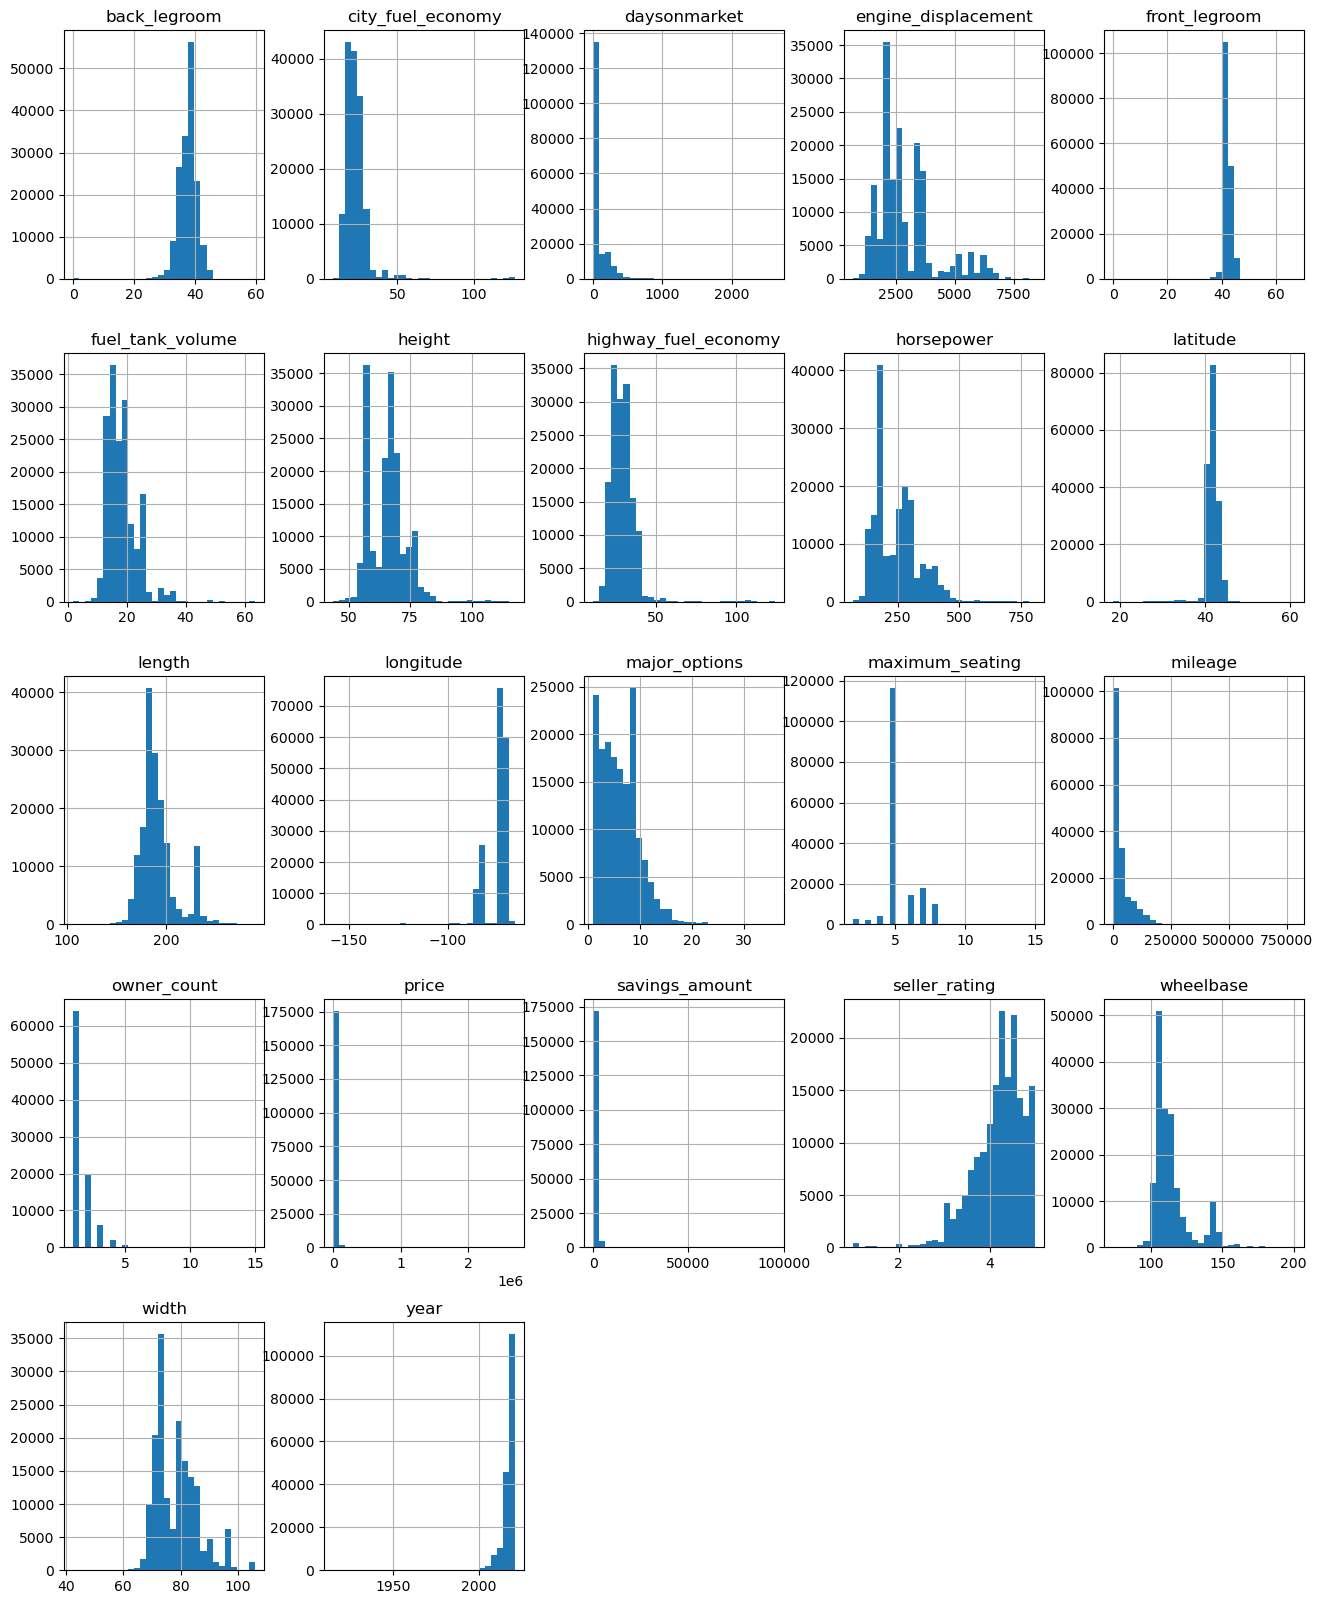

In [31]:
import matplotlib.pyplot as mpl
%matplotlib inline

df_numerical = df.select_dtypes(include=[np.int64, np.float64]).drop(columns=['listing_id', 'sp_id'])
df_numerical.hist(figsize=(16,20), bins=30)
mpl.show()

Observations:
- Both Fuel economy attributes appear to be normally distributed with a slight skew
- Majority of cars do not stay on the market for a long duration, mostly less than a couple of months. Some may be above a large amount so these may need to be removed to not skew data.
- Engine displacement doesn't appear to have any obvious standard distribution
- Horsepower appears to have a normal distribution around 200hp with a standard deviation of around 50hp
- Lattitude is as expected all grouped together around 39 to 44 
- longitutde is split into two peaks, most likely corresponding to central US and alaska
- Milegae of most cars is grouped mostly around 0 and fewer cars with higher mileage, as would be expected
- owner count has a modal of 1, again as to be expected
- Most cars prices are group around the same order of magnitutde. Howeever some extremes are seen. A logarithmic transformation may need to be considered later.
- Seller ratings appear to be skew negatively towards the higher end
- Majority of cars are from the last 15 years
- Modal max seats is 5

It is clear as well that some of the bins are very sparse so will need coarser bins with labels for our model later to make sure our training set and test set have similar distributions.

**NOTE: with the data already being sampled, there will not be any exploratory analysis that would unfairly influence performance on the test data**

Now we've seen the data roughly let's start to deal with skew issues.



In [35]:
df.select_dtypes(include=[np.float64, np.int64]).count() / sample_size

back_legroom            0.917186
city_fuel_economy       0.834840
daysonmarket            1.000000
engine_displacement     0.948004
front_legroom           0.944935
fuel_tank_volume        0.950801
height                  0.951230
highway_fuel_economy    0.834840
horsepower              0.948004
latitude                1.000000
length                  0.951235
listing_id              1.000000
longitude               1.000000
major_options           0.923492
maximum_seating         0.951213
mileage                 0.959244
owner_count             0.523686
price                   1.000000
savings_amount          1.000000
seller_rating           0.986357
sp_id                   0.999797
wheelbase               0.951235
width                   0.951230
year                    1.000000
dtype: float64

Firstly it is clear to see there is no issue with the attributes: `daysonmarket`, `lattitude`, `longitude`, `price`, `savings_amount` and `year`.

In [ ]:
### GOOD ###

In [ ]:
##df[df.select_dtypes(include=[np.int64, np.float64]).isnull().any(axis=1)].select_dtypes(include=[np.int64, np.float64]).isnull().any()

So we have an issue with engine_displacement, horsepower and owner_count. Let's see how severe this issue is.

In [ ]:
df[['engine_displacement', 'horsepower', 'owner_count']].count() / data_original_length

For the horsepower attribute after further inspection into the data, it can be seen that the horsepower attribute is actually contained within the power attribute(see example below).

In [ ]:
# Example of horsepower contained in two attributes
df.loc[1, ['horsepower', 'power']]

First let's see if there is enough attributes from either horsepower and power for each entry to get a car's horsepower.

In [ ]:
df_no_hp = df[df['horsepower'].isna() & df['power'].isna()]

There is also another useful attribute of RPM which could help to distinguish between performance cars with large horsepower and 4x4 with the same, but there may be too many NAs for this attribute to use this metric, let's see.

In [ ]:
len(df_no_hp) / data_original_length

So from above we can see that only around 5% have no power or horsepower attribute. For these remaining entries we will consider how many have engine size attributes.

In [ ]:
df_no_hp_engine_size = df[df.engine_type.isna() & df.power.isna() & df.horsepower.isna()]
len(df_no_hp_engine_size) / len(df)

Now there is only a small amount of cars with neither horsepower, power or engine_type attribute. All these entries will simply take the overall average for horsepower.

The horsepower for all cars will be assigned using the following:

- If the car has horspower asigned pass
- If the car has power but no horsepower, find horsepower from power
- If the car has neither assign the horsepower as the average of a car for the given engine_type
- If the car has none of these assign the overall average for horsepower

This will be done later in a pipeline when preparing the data

In [ ]:
def get_power_data(s: str):
    """
    Returns the hp and RPM from the power string
    attribute of a vehicle
    """
    if not pd.isna(s):
        try:
            string_split: list = s.split(" ")
            return string_split[0], string_split[3].replace(",", "")
        except AttributeError:
            pass
    return np.nan, np.nan

# Example of usage
#zip(*map(get_power_data, df.engine_size))

In [ ]:
df.horsepower = df[['horsepower', 'power', 'engine_size']].apply(lambda x: x['horsepower'] if not pd.isna(x['horsepower'])
                         else (x.power if not x.power.isna() else get_power_data(x.engine_size)[0]))

In [ ]:
###################################################

Now all the qualitative data which was numeric has been converted. Only the categorical data will be left, this can be seen below.

In [ ]:
df.select_dtypes(include=object).head(5)

In [ ]:
df.select_dtypes(include=object).count() / sample_size

Clearly there is severe issues with 'owner_count'. Now this could be an important metric, however the 'mileage' attribute will likely be able to show similar information implicitly, but with likely more detail since it is a continuous not descrete attribute. Hence the owner_count will be ommitted.

In [ ]:
df = df.drop(columns='owner_count')

## Explore correlations

Firstly let's explore the correlation between all the numerical attributes and the price

In [32]:
df_numerical = df.select_dtypes(include=[np.float64, np.int64])
# abs taken as don't care if posotive or negative effect
corr_series = abs(df_numerical.drop("price", axis=1).apply(lambda x: x.corr(df_numerical.price)))
corr_series

back_legroom            0.238732
city_fuel_economy       0.148726
daysonmarket            0.097697
engine_displacement     0.304852
front_legroom           0.031593
fuel_tank_volume        0.339290
height                  0.229851
highway_fuel_economy    0.216178
horsepower              0.577948
latitude                0.003607
length                  0.308462
listing_id              0.093082
longitude               0.037972
major_options           0.272946
maximum_seating         0.099018
mileage                 0.448651
owner_count             0.213313
savings_amount          0.002705
seller_rating           0.059301
sp_id                   0.137246
wheelbase               0.312001
width                   0.369476
year                    0.358073
dtype: float64

Now let's choose all attributes with a correlation of more than 0.3 and use some of our contextual knowledge to inspect.

In [33]:
corr_series[corr_series > 0.3]

engine_displacement    0.304852
fuel_tank_volume       0.339290
horsepower             0.577948
length                 0.308462
mileage                0.448651
wheelbase              0.312001
width                  0.369476
year                   0.358073
dtype: float64

All these attributes seem to make logical sense. One attribute that could be removed is one of `wheelbase` or `length` since they represent different ways to measure the length of a car. Since wheelbase has the higher correlation, `length` will be dropped. Let's inspect the above attributes in more detail.

In [ ]:
#df = df.drop(columns='length')
corr_series = corr_series.drop('length')
corr_series

In [ ]:
pd.plotting.scatter_matrix(df[corr_series[corr_series > 0.3].keys().to_list() + ['price']], figsize=(15,15))
mpl.show()

Inspecting the price row (or column), horsepower and mileage have the stongest correlation as to be expected. 
wheelbase and width appear to have similar correlation to price, which is to be expected by them being a measurement of size.

In [ ]:
###########################################################

In [ ]:
df.loc[:, (df.count() / len(df.index)) < 0.95]

As most a large amount of the attributes are categorical or boolean, changing the remaining NAs to the average of the column would not make much sense. Furthermore, since the dataset is very large, removing NAs is unlikely to heavily impact the model. However to make sure the one type of car or manufactor is not being discrimanted against before they're removed the entries with NAs will be inspected.

In [ ]:
car_makes_with_NA = df1[df1.isnull().any(axis=1)].make_name.unique()
df_prepared = df1[~df1.isnull().any(axis=1)]
car_makes_no_NA = df_prepared.make_name.unique()

(set(car_makes_no_NA) and set(car_makes_with_NA)) == set(car_makes_with_NA)

This means all car makes are being represented still even when NA rows are removed.

Now the data has been filtered, the exploration of relationships can begin. Note that only 4% of the entries have been removed.

In [ ]:
round(len(df_prepared.index) / data_original_length, 2)

In [ ]:
used_cars_prices = df_prepared["price"].copy()
used_cars_prices.head()

In [ ]:
# os.chdir(folder_path)
# file_names : list = [i for i in glob.glob("*.{}".format('csv'))]
# df = pd.concat(map(read_car_data, file_names))


## Choosing attributes

Inspecting this list and using our contextual knowledge of cars, as well as the info available on the [kaggle page](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset). Certain attributes can be removed immediately, leaving ones that are believed to influence the price. Any attributes left will be further inspected before any models are used. 

Note: data types are now defined to make sure any further exploration is done correctly.

In [ ]:
# Attributes belived to influence price
desired_attributes : list = ["body_type", "city", "daysonmarket", "dealer_zip", "engine_cylinders", "engine_displacement",
                             "engine_type", "fleet", "frame_damaged", "franchise_dealer", "fuel_tank_volume", "has_accidents", "horsepower",
                            "is_new", "listed_date", "make_name", "owner_count", "power", "price",
                             "savings_amount", "seller_rating", "year", "torque"
                            ]
    
# REMOEVE ANY IRRELEVANT ONES
# Define datatypes of attributes to make sure any exploration is good.
data_types = {'vin' : str, 'back_legroom' : str, 'bed' : str, 'bed_height' : str,
              'bed_length' : str, 'body_type' : str, 'cabin' : str, 'city' : str,
              'city_fuel_economy' : np.float64, 'combine_fuel_economy' : np.float64,
              'daysonmarket' : np.int32, 'dealer_zip' : np.int32, 'description' : str, 
              'engine_cylinders' : str, 'engine_displacement' : np.float64,
              'engine_type' : str, 'exterior_color' : str, 'fleet' : bool, 'frame_damaged' : bool,
              'franchise_dealer' : bool, 'franchise_make' : str, 'front_legroom' : str,
              'fuel_tank_volume' : str, 'fuel_type' : str, 'has_accidents' : bool, 'height' : str,
            'highway_fuel_economy' : np.float64, 'horsepower' : np.float64, 'interior_color' : str, 'isCab' : bool,
            'is_certified' : bool, 'is_cpo' : bool, 'is_new' : bool, 'is_oemcpo' : bool, 'latitude' : np.float64, 'length' : str,
            'listed_date' : str, 'listing_color' : str, 'listing_id' : np.int32, 'longitude' : np.float64,
            'main_picture_url' : str, 'major_options' : str, 'make_name' : str, 'maximum_seating' : np.int32,
            'mileage' : np.int32, 'model_name' : str, 'owner_count' : np.int32, 'power' : str, 'price' : np.float64, 'salvage' : bool,
            'savings_amount' : np.int32 , 'seller_rating' : np.float64, 'sp_id' : np.int32, 'sp_name' : str, 'theft_title' : bool,
            'torque' : str, 'transmission' : str, 'transmission_display' : str, 'trimId' : np.int32, 'trim_name' : str,
            'vehicle_damage_category' : str, 'wheel_system' : str, 'wheel_system_display' : str,
            'wheelbase' : str, 'width' : str, 'year' : np.int32}

    
df = df[df.columns.intersection(desired_attributes)].convert_dtypes(data_types).copy()
df = df.reset_index(drop=True) # Let's also reset the index to stop using vin